In [1]:
import numpy as np
import h5py
import torch
import torchmetrics
import torch.nn.functional as F
import pytorch_lightning as pl
from sklearn.preprocessing import OneHotEncoder 
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torch.nn import BatchNorm1d, Linear, ReLU, Sequential, MSELoss, Softmax, CrossEntropyLoss
from torch_geometric.nn import DynamicEdgeConv, global_mean_pool
from torch_geometric.data import Batch

import matplotlib.pyplot as plt

In [2]:
path='../project_data/small_set_1_train_0_shuffled.h5'


In [3]:
class HDF5Dataset(Dataset):
    def __init__(self, path, features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="particle_type", particle_type=13.0, batch_size=16):
        """ Loads the data from the hdf5 format provided by OrcaSong and converts it to data that can be used by PyTorch
        
        Args:
            path (str): path to the dataset
            features (list[str]): List of features to select from the event data and use as input features
            y_feature  (str): Output feature to select
            particle_type (None or float):  ID of the particle you want to classify, it will be label 0 and all else will be label 1.
                                            Must be None when y_feature is not `particle_type`
            batch_size (int): number of samples in mini batch
        Examples:
            Electron vs Background classification (default):
            ```
                HDF5Dataset("pathtodata.h5", y_feature="particle_type", particle_type=13.0)
            ```
            Energy regression with only xyzct:
            ```
                HDF5Dataset("pathtodata.h5", features=["pos_x", "pos_y", "pos_z", "time"], y_feature="energy", particle_type=None)
            ```

        Lookup of table for particle_type of Leptons:
          electron          | 11
          electron neutrino | 12
          muon              | 13
          muon neutrino     | 14
          tau               | 15
          tau neutrino      | 16
        Antiparticle is the same as particle but with minus sign
        Source: https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf
        """
        with h5py.File(path, "r") as f:
            self.groups = list(dict(f).keys())
            self.length = len(f["y"]) // batch_size + 1
            self._max_index = len(f["y"])
            print("The available y features are: ", f["y"][0].dtype.names)
        self.filename = path
        if y_feature!="particle_type":
            assert particle_type==None, "Selected a y_feature other than 'particle_type' and specified some value for particle_type as argument, which must be None for non particle_type output feature."
        self.y_feature = y_feature
        self.particle_type = particle_type
        self.batch_size = batch_size
        self._cache_x_column_names()
        self.x_mask = self.init_x_mask(features)


    def _cache_x_column_names(self):
        """Cache which columns are available in the features

        Raises:
            ValueError: It failed to read the hit_info columns
        """
        try:
            with h5py.File(self.filename, "r") as f:
                self.x_feature_dict = {
                    f["x"].attrs[f"hit_info_{i}"]: i for i in range(f["x"].shape[-1])
                }
            print("cached the following x input features", self.x_feature_dict)
        except Exception:
            raise ValueError("Can not read column names from dataset attributes")

    def init_x_mask(self, features):
        """Compute a mask that is used to select the feature columns from the data

        Args:
            features (list[str]): list of features present to load

        Returns:
            np.array: selection of column index from the features to use
        """
        x_mask = [self.x_feature_dict[feat] for feat in features]
        return np.array(x_mask)

    def __getitem__(self, index):
        """Get an sample from the h5 dataset
        x contains: (x,y,z,ct, dir_x, dir_y, dir_z)
        y contains a label 

        Args:
            index (int): index of the batch

        Returns:
            x (torch.Tensor): Tensor with the x data (for each of the vertices)
            y (torch.Tensor): Tensor with the y data (for the graph)
            batch_idx (torch.Tensor): Tensor that assigns the right batch index to each x point
        """
        with h5py.File(self.filename, "r") as f:
            index = slice(index * self.batch_size, min(self._max_index,(index + 1) * self.batch_size))
            
            x = f["x"][index]
            lengths = (np.sum(x[:, :, -1:], axis=1)).astype(int)
            batch_idx = np.hstack(
                  [
                      np.ones(length) * batch_idx
                      for batch_idx, length in enumerate(lengths)
                  ]
              )
            x = x[x[:, :, -1] == 1][:, self.x_mask]
            y = f["y"][index][self.y_feature].reshape(-1,1)
            y = torch.Tensor(y.copy())
            
        return x, y, torch.LongTensor(batch_idx)

    def __len__(self):
        return self.length

In [4]:
trian_data=train_data = HDF5Dataset(path,features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="dir_z",particle_type=None,batch_size=16)
x,y,i=train_data.__getitem__(1)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}


In [4]:
class DECNetwork(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        #self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 8, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU(),
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=32)
        
        nn = Sequential(
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
            Linear(128, 128),
            BatchNorm1d(128),
            ReLU(),
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=32)

        self.shortcut_1 = Sequential(Linear(8, 64), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(64, 128), BatchNorm1d(128), ReLU())


        self.lin_2 = Linear(128, 128)
        self.lin_3 = Linear(128, 1)

    
    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
      
        x = global_mean_pool(x, batch=batch_idx)
        # now apply

        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return torch.tanh(x).squeeze()
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.mse_loss(out, batch.y)
        self.log("train_loss", loss)
        #self.log('train_acc_step', self.accuracy(out, batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log("val_loss", loss)
        #self.log('valid_acc', self.accuracy(y_hat, batch.y), on_step=True, on_epoch=True)
        #self.log('valid_matrix', self.confusionmatrix(F.softmax(y_hat), batch.y), on_epoch=True)
    
    def test_step(self,batch,batch_idx):
        batch = Batch(
            x=batch[0].squeeze(),y=batch[1].squeeze(),batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        predictions_pred.append(y_hat)
        predictions_actual.append(batch.y)
        
        self.log("test_loss", loss)
        #self.log('test_acc', self.accuracy(y_proba, batch.y), on_step=True, on_epoch=True)
        return {'test_loss': loss, 'y': batch.y, 'y_pred': y_hat}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


In [14]:
class DEC_small(pl.LightningModule):
    def __init__(self, batchnorm_kwargs=None, conf=None):
        """Dynamic EdgeConvolution Network https://arxiv.org/abs/1801.07829 with
           the dynamic KNN computation as presented in https://arxiv.org/abs/1902.08570 """
        super().__init__()
        ## Lightning configuration
        #self.accuracy = pl.metrics.Accuracy()
        ## Defining the Network Architecture
        nn = Sequential(
            Linear(2 * 8, 32),
            BatchNorm1d(32),
            ReLU(),
            Linear(32, 32),
            BatchNorm1d(32),
            ReLU()
        )
        self.edge_1 = DynamicEdgeConv(nn, aggr="mean", k=8)
        
        nn = Sequential(
            Linear(32, 64),
            BatchNorm1d(64),
            ReLU(),
            Linear(64, 64),
            BatchNorm1d(64),
            ReLU()
        )
        self.edge_2 = DynamicEdgeConv(nn, aggr="mean", k=16)

        self.shortcut_1 = Sequential(Linear(8, 32), BatchNorm1d(64), ReLU())
        self.shortcut_2 = Sequential(Linear(32, 64), BatchNorm1d(128), ReLU())

        self.lin_2 = Linear(64, 64)
        self.lin_3 = Linear(64, 1)

    
    def forward(self, data):
        x, batch_idx = data.x, data.batch
        # in lightning, forward defines the prediction/inference actions
        # edgeconv layer 1
        sc = self.shortcut_1(x)
        x = self.edge_1(x, batch_idx)
        x = F.relu(x + sc)
        # edgeconv layer 2
        sc = self.shortcut_2(x)
        x = self.edge_2(x, batch_idx)
        x = F.relu(x + sc)
      
        x = global_mean_pool(x, batch=batch_idx)
        # now apply

        x = F.relu(self.lin_2(x))
        x = self.lin_3(x)
        return torch.tanh(x).squeeze()
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop. It is independent of forward
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        out = self.forward(batch)
        loss = F.mse_loss(out, batch.y)
        self.log("train_loss", loss)
        #self.log('train_acc_step', self.accuracy(out, batch.y), on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):
        batch = Batch(
            x=batch[0].squeeze(), y=batch[1].squeeze(), batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
        self.log("val_loss", loss)
        #self.log('valid_acc', self.accuracy(y_hat, batch.y), on_step=True, on_epoch=True)
        #self.log('valid_matrix', self.confusionmatrix(F.softmax(y_hat), batch.y), on_epoch=True)
    
    def test_step(self,batch,batch_idx):
        batch = Batch(
            x=batch[0].squeeze(),y=batch[1].squeeze(),batch=batch[2].squeeze(),
        )
        y_hat = self.forward(batch)
        loss = F.mse_loss(y_hat, batch.y)
   
        predictions_pred.append(y_hat)
        predictions_actual.append(batch.y)
        
        self.log("test_loss", loss)
        #self.log('test_acc', self.accuracy(y_proba, batch.y), on_step=True, on_epoch=True)
        return {'test_loss': loss, 'y': batch.y, 'y_pred': y_hat}
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


Testing:  58%|█████▊    | 7450/12843 [08:48<06:54, 13.01it/s]

In [5]:
trian_data=train_data = HDF5Dataset(path,features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="dir_z",particle_type=None,batch_size=16)

train_loader = DataLoader(
    train_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
val_data = HDF5Dataset("../project_data/small_set_1_validate_0_shuffled.h5",features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="dir_z",particle_type=None,batch_size=32)
val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}
The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 

In [7]:
model = DECNetwork()

In [9]:
model = DECNetwork().load_from_checkpoint('lightning_logs/version_36/checkpoints/epoch=3-step=102743.ckpt')

In [6]:
trainer = pl.Trainer(
    max_epochs=10,
    gpus=1,
    precision=32,
    log_every_n_steps=1000,
    progress_bar_refresh_rate=10,
    fast_dev_run=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [11]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type            | Params
-----------------------------------------------
0 | edge_1     | DynamicEdgeConv | 9.8 K 
1 | edge_2     | DynamicEdgeConv | 50.3 K
2 | shortcut_1 | Sequential      | 704   
3 | shortcut_2 | Sequential      | 8.6 K 
4 | lin_2      | Linear          | 16.5 K
5 | lin_3      | Linear          | 129   
-----------------------------------------------
86.0 K    Trainable params
0         Non-trainable params
86.0 K    Total params
0.344     Total estimated model params size (MB)


Epoch 0:  67%|██████▋   | 25690/38529 [52:47<26:22,  8.11it/s, loss=0.0353, v_num=43] 
Validating: 0it [00:00, ?it/s]
Epoch 1:  67%|██████▋   | 25690/38529 [52:47<26:23,  8.11it/s, loss=0.0351, v_num=43]  
Validating: 0it [00:00, ?it/s]
Epoch 2:  67%|██████▋   | 25690/38529 [52:47<26:23,  8.11it/s, loss=0.0347, v_num=43]  
Validating: 0it [00:00, ?it/s]
Epoch 3:  67%|██████▋   | 25690/38529 [52:48<26:23,  8.11it/s, loss=0.0328, v_num=43]  
Validating: 0it [00:00, ?it/s]
Epoch 4:  67%|██████▋   | 25690/38529 [52:48<26:23,  8.11it/s, loss=0.0328, v_num=43]  
Validating: 0it [00:00, ?it/s]
Epoch 5:  55%|█████▍    | 21010/38529 [43:03<35:54,  8.13it/s, loss=0.0325, v_num=43]  


/home/laurens/.local/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [12]:
trainer.save_checkpoint(trainer.log_dir+"/trained_model.ckpt")

Run nummer 43!

In [7]:
model = DECNetwork().load_from_checkpoint('lightning_logs/version_43/trained_model.ckpt')

In [8]:
val_data = HDF5Dataset( "../project_data/small_set_1_validate_0_shuffled.h5",features=["pos_x", "pos_y", "pos_z", "time","tot", "dir_x", "dir_y", "dir_z"], y_feature="dir_z",particle_type=None,batch_size=32)

The available y features are:  ('event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x', 'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x', 'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2', 'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y', 'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x', 'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length', 'group_id')
cached the following x input features {'channel_id': 0, 'dir_x': 1, 'dir_y': 2, 'dir_z': 3, 'dom_id': 4, 'du': 5, 'floor': 6, 'group_id': 7, 'pos_x': 8, 'pos_y': 9, 'pos_z': 10, 't0': 11, 'time': 12, 'tot': 13, 'triggered': 14, 'is_valid': 15}


In [9]:
val_loader = DataLoader(
    val_data,
    batch_size=1,
    num_workers=4,
    pin_memory=True,
    shuffle=False,
)
predictions_pred = []
predictions_actual = []
trainer.test(model,val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 100%|██████████| 2493/2493 [02:44<00:00, 15.14it/s]
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.03626566752791405}
--------------------------------------------------------------------------------


[{'test_loss': 0.03626566752791405}]

In [10]:
y_pred=np.empty(1)
y_actual=np.empty(1)
for i in range(len(predictions_pred)):
    y_pred=np.vstack([y_pred,predictions_pred[i].cpu().numpy().reshape(-1,1)])
    y_actual=np.vstack([y_actual,predictions_actual[i].cpu().numpy().reshape(-1,1)])

In [14]:
y_pred[1:]

array([[-0.9265421 ],
       [-0.24452257],
       [-0.82064116],
       ...,
       [-0.59446168],
       [ 0.17677207],
       [ 0.71467531]])

In [15]:
y_actual[1:]

array([[-0.90676302],
       [-0.38769299],
       [-0.84148198],
       ...,
       [-0.64960998],
       [ 0.087527  ],
       [ 0.407123  ]])

In [11]:
import pandas as pd
path="../project_data/small_set_1_validate_0_shuffled.h5"
with h5py.File(path, "r") as f:
    df=pd.DataFrame(f['y'][:])

df.columns

Index(['event_id', 'particle_type', 'energy', 'is_cc', 'bjorkeny', 'dir_x',
       'dir_y', 'dir_z', 'time_interaction', 'run_id', 'vertex_pos_x',
       'vertex_pos_y', 'vertex_pos_z', 'n_hits', 'weight_w1', 'weight_w2',
       'weight_w3', 'n_gen', 'prod_identifier', 'std_dir_x', 'std_dir_y',
       'std_dir_z', 'std_beta0', 'std_lik', 'std_n_hits_gandalf', 'std_pos_x',
       'std_pos_y', 'std_pos_z', 'std_energy', 'std_lik_energy', 'std_length',
       'group_id'],
      dtype='object')

In [12]:
df['pred_angle']=np.rad2deg(np.arccos(y_pred[1:]))
df['true_angle']=np.rad2deg(np.arccos(df.dir_z))
df['relative_error_A']=100*(np.abs(df.true_angle-df.pred_angle)/np.abs(df.true_angle))
df['error_A']=(np.abs(df.true_angle-df.pred_angle))

In [13]:
particle_names={-13:'muon',14:'muon neutrino',-14:'muon neutrino',12:'electron neutrino',-12:'electron neutrino'}
df['particles']=df.particle_type.map(particle_names)

In [47]:
bins=[x*5 for x in range(8)]

In [48]:
df['energy_bins']=pd.cut(df['energy'],bins=bins)

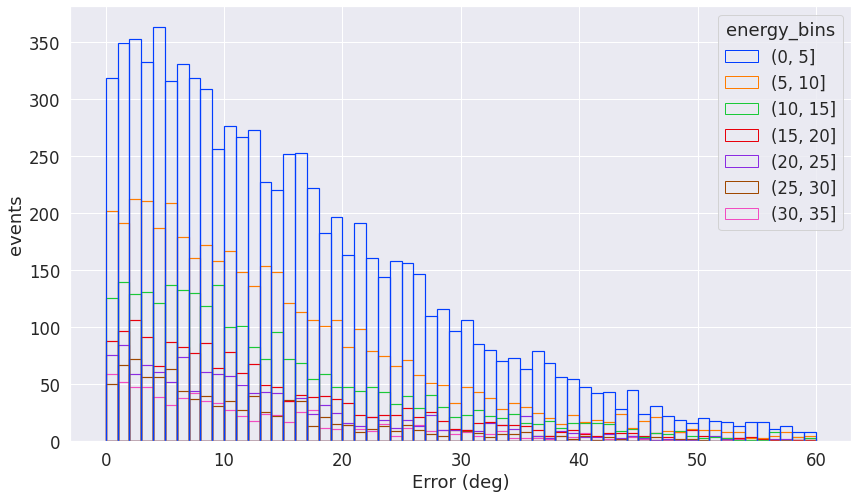

In [49]:
sns.set(rc={"figure.figsize":(14, 8)},font_scale=1.5) 
sns_plot = sns.histplot(data = df.loc[df.energy<40], x='error_A',hue='energy_bins',multiple="layer",fill=False,binwidth = 1, binrange=[0,60], palette="bright")
sns_plot.set(xlabel ="Error (deg)",ylabel="events")
#sns_plot.set_xticks([x/4 for x in range(12)])
fig = sns_plot.get_figure()
#fig.savefig("angle_error.pdf")
#fig.savefig("angle_error.png")

In [14]:

import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [15]:
#import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

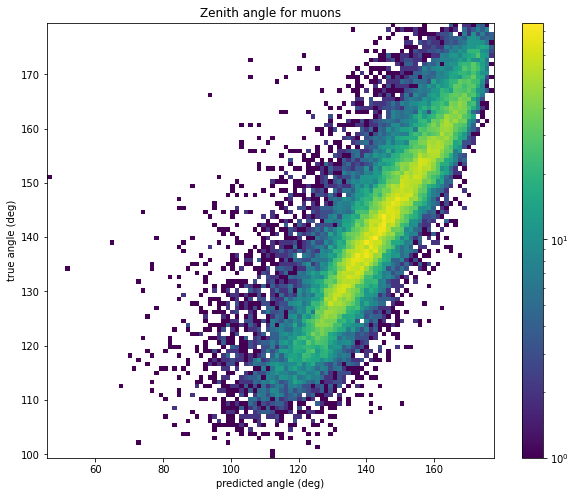

<Figure size 432x288 with 0 Axes>

In [16]:
x=df.loc[df.particles=='muon'].pred_angle.values
y=df.loc[df.particles=='muon'].true_angle.values
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,100,norm=LogNorm(),cmap='viridis')
plt.colorbar()
plt.title('Zenith angle for muons')
plt.xlabel('predicted angle (deg)')
plt.ylabel('true angle (deg)')
plt.show() 
plt.savefig('angle_error_muons.pdf')
plt.savefig('angle_error_muons.png')

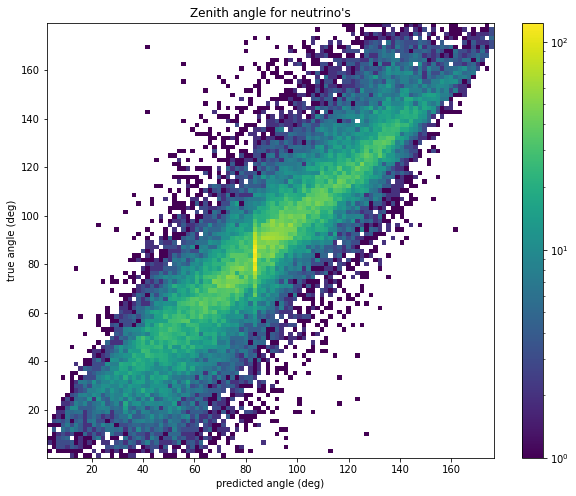

<Figure size 432x288 with 0 Axes>

In [17]:

x=df.loc[df.particles!='muon'].pred_angle.values
y=df.loc[df.particles!='muon'].true_angle.values
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,100,norm=LogNorm(),cmap='viridis')
plt.colorbar()
plt.title("Zenith angle for neutrino's")
plt.xlabel('predicted angle (deg)')
plt.ylabel('true angle (deg)')
plt.show() 
plt.savefig('angle_error_neutrinos.pdf')
plt.savefig('angle_error_neutrinos.png')


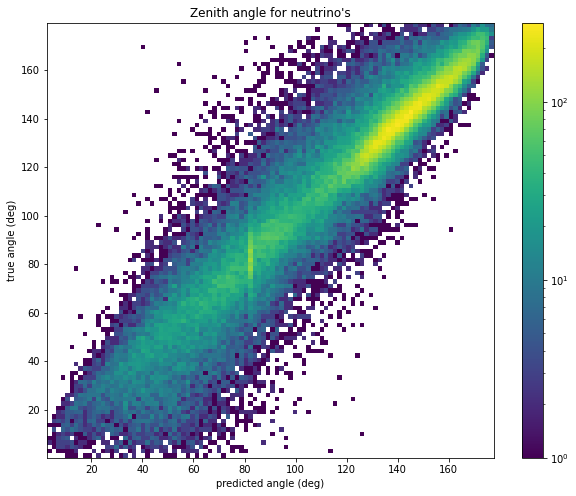

<Figure size 432x288 with 0 Axes>

In [18]:

x=df.pred_angle.values
y=df.true_angle.values
fig = plt.figure(figsize=(10,8))
_,_,_,axs=plt.hist2d(x,y,100,norm=LogNorm(),cmap='viridis')
plt.colorbar()
plt.title("Zenith angle for neutrino's")
plt.xlabel('predicted angle (deg)')
plt.ylabel('true angle (deg)')
plt.show() 
plt.savefig('angle_error_neutrinos.pdf')
plt.savefig('angle_error_neutrinos.png')

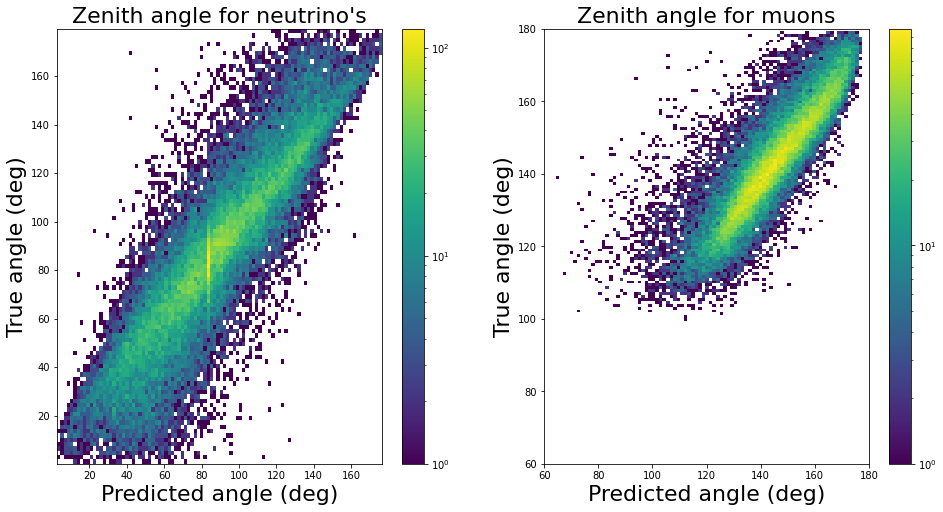

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
x=df.loc[df.particles!='muon'].pred_angle.values
y=df.loc[df.particles!='muon'].true_angle.values
pcm0=axs[0].hist2d(x,y,100,norm=LogNorm(),cmap='viridis')
x=df.loc[df.particles=='muon'].pred_angle.values
y=df.loc[df.particles=='muon'].true_angle.values
pcm1=axs[1].hist2d(x,y,100,norm=LogNorm(),cmap='viridis')
axs[0].set_xlabel('Predicted angle (deg)',fontsize = 22)
axs[1].set_xlabel('Predicted angle (deg)',fontsize = 22)
axs[0].set_ylabel('True angle (deg)',fontsize = 22)
axs[1].set_ylabel('True angle (deg)',fontsize = 22)
fig.colorbar(pcm0[-1],ax=axs[0])
fig.colorbar(pcm1[-1],ax=axs[1])
axs[1].set_xlim([60, 180])
axs[1].set_ylim([60, 180])
axs[0].set_title("Zenith angle for neutrino's",fontsize = 22)
axs[1].set_title("Zenith angle for muons",fontsize = 22)
plt.show()
fig.savefig("angle_prediction_2.pdf")
fig.savefig("angle_prediction_2.png")

In [37]:
df_short= df.loc[df.energy<100]
bins = pd.cut(df_short.energy,bins=[x*10 for x in range(11)],labels=[(x+1)*10 for x in range(10)])

In [41]:
data=df_short[['error_A']].groupby(bins).median()/
data

,error_A
energy,
10,12.971134
20,10.710542
30,10.101705
40,9.634870
50,8.366872
60,7.861634
70,8.359986
80,8.615051
90,7.668405


No handles with labels found to put in legend.


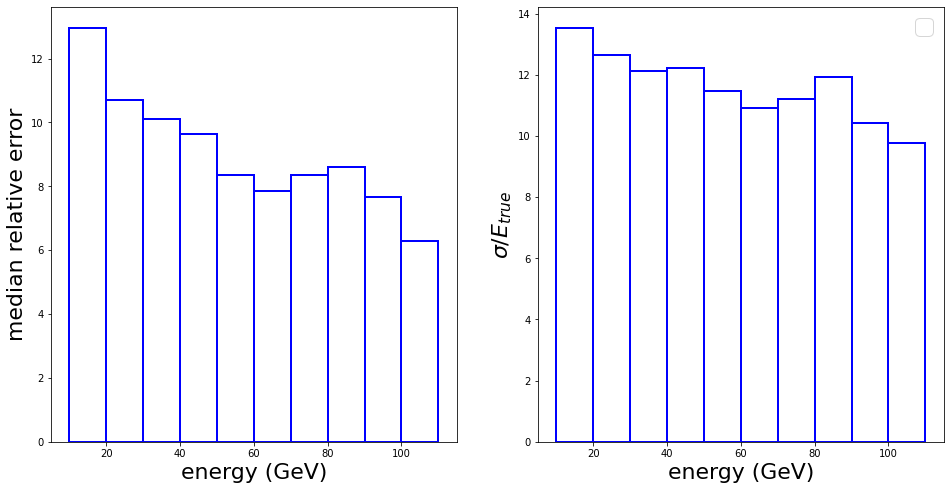

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].bar(data.index,data.error_A,width=10,align='edge',fill=False,edgecolor='b',linewidth=2)
axs[1].bar(std.index,std.error_A,width=10,align='edge',fill=False,edgecolor='b',linewidth=2)
axs[0].set_xlabel('energy (GeV)',fontsize = 22)
axs[1].set_xlabel('energy (GeV)',fontsize = 22)
axs[0].set_ylabel('median relative error',fontsize = 22)
axs[1].set_ylabel('$\\sigma / E_{true}$',fontsize = 22)
#plt.legend(fontsize = 22, loc="best")
plt.show()
#fig.savefig("rel_error.pdf")
#fig.savefig("rel_error.png")